In [1]:
import zarr
import os

In [2]:

def explore_zarr(path):
    print(f"\n=== Exploring Zarr file: {path} ===\n")
    root = zarr.open(path, mode='r')

    def explore(node, prefix=""):
        # Group
        if isinstance(node, zarr.hierarchy.Group):
            print(f"{prefix}[Group] {node.name or '/'}")
            
            # Print group attributes
            if node.attrs:
                print(f"{prefix}  Attributes:")
                for k, v in node.attrs.items():
                    print(f"{prefix}    {k}: {v}")
            
            # Recursively explore children
            for key, item in node.items():
                explore(item, prefix + "  ")

        # Array
        elif isinstance(node, zarr.core.Array):
            print(f"{prefix}[Array] {node.name}")
            print(f"{prefix}  Shape       : {node.shape}")
            print(f"{prefix}  Dtype       : {node.dtype}")
            print(f"{prefix}  Chunks      : {node.chunks}")
            print(f"{prefix}  Compressor  : {node.compressor}")
            
            # Print array attributes
            if node.attrs:
                print(f"{prefix}  Attributes:")
                for k, v in node.attrs.items():
                    print(f"{prefix}    {k}: {v}")

            print()

    explore(root)


In [3]:


# Run the explorer
explore_zarr("./dumpling_new_40demo_1024.zarr/")     # Replace with your path



=== Exploring Zarr file: ./dumpling_new_40demo_1024.zarr/ ===

[Group] /
  [Group] /data
    [Array] /data/action
      Shape       : (4539, 22)
      Dtype       : float32
      Chunks      : (100, 22)
      Compressor  : Blosc(cname='zstd', clevel=3, shuffle=SHUFFLE, blocksize=0)

    [Array] /data/depth
      Shape       : (4539, 84, 84)
      Dtype       : float64
      Chunks      : (100, 84, 84)
      Compressor  : Blosc(cname='zstd', clevel=3, shuffle=SHUFFLE, blocksize=0)

    [Array] /data/img
      Shape       : (4539, 84, 84, 3)
      Dtype       : uint8
      Chunks      : (100, 84, 84, 3)
      Compressor  : Blosc(cname='zstd', clevel=3, shuffle=SHUFFLE, blocksize=0)

    [Array] /data/point_cloud
      Shape       : (4539, 1024, 6)
      Dtype       : float64
      Chunks      : (100, 1024, 6)
      Compressor  : Blosc(cname='zstd', clevel=3, shuffle=SHUFFLE, blocksize=0)

    [Array] /data/state
      Shape       : (4539, 22)
      Dtype       : float32
      Chunks    

=== ACTION (shape: 22) ===
[ 0.          0.          0.          0.          0.          0.
  0.18869552 -0.04749171  0.49455002  0.4421248   0.21191649  0.20984782
  0.39610243  0.3226929   0.0560485   0.42907164  0.13651757  0.05535783
  0.          0.06494521  0.1687036  -0.08858166]

=== STATE (shape: 22) ===
[ 0.585916    0.          0.359059   -0.742207   -0.12834     0.043956
  0.15895818  0.34576994  0.5878444   0.649735    0.33286014  0.67136925
  0.40405586  0.42838478  0.47        1.0031441   0.19868378  0.20021886
  0.263      -0.03749211  1.2137995   0.23740087]

=== DEPTH (shape: 84x84) ===
[[4128.71435547 4150.31103516 4169.8046875  ...    0.
     0.            0.        ]
 [4128.85693359 4159.5        4171.35693359 ... 6544.86767578
  6519.21435547 6507.74658203]
 [4126.39990234 4168.31152344 4207.73779297 ... 6557.54931641
  6543.35742188 6498.91992188]
 ...
 [3438.95043945 3417.35717773 3438.99633789 ... 3955.45898438
  3965.22949219 3959.78564453]
 [3390.5        337

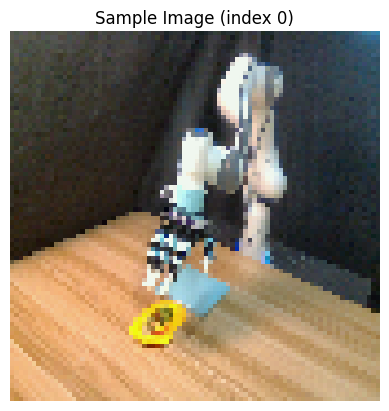

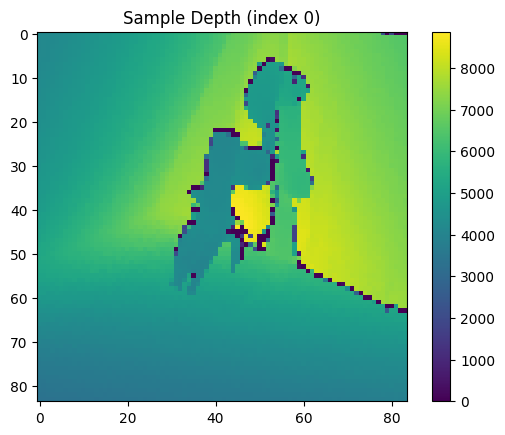

In [4]:
import zarr
import matplotlib.pyplot as plt

# Load your dataset
root = zarr.open("./roll_40demo_1024.zarr", mode='r')
data = root["data"]

# Extract one sample (index 0)
img = data["img"][0]                # (84,84,3)
depth = data["depth"][0]            # (84,84)
action = data["action"][0]          # (22,)
state = data["state"][0]            # (22,)
point_cloud = data["point_cloud"][0]  # (1024, 6)

# Print numeric arrays
print("=== ACTION (shape: 22) ===")
print(action)

print("\n=== STATE (shape: 22) ===")
print(state)

print("\n=== DEPTH (shape: 84x84) ===")
print(depth)

print("\n=== POINT CLOUD (shape: 1024x6) ===")
print(point_cloud)

# Display image
plt.imshow(img)
plt.title("Sample Image (index 0)")
plt.axis("off")
plt.show()

# Display depth map
plt.imshow(depth)
plt.title("Sample Depth (index 0)")
plt.colorbar()
plt.show()


In [5]:
import zarr
import imageio
import numpy as np

# Load dataset
root = zarr.open("./roll_40demo_1024.zarr", mode='r')
imgs = root["data"]["img"][:]      # shape: (3196, 84, 84, 3)

frames = []

# Convert each frame
for i in range(len(imgs)):
    frame = imgs[i].astype(np.uint8)
    frames.append(frame)

# Save GIF using 'duration' instead of fps
imageio.mimsave("scene.gif", frames, duration=50)   # 50 ms per frame -> 20 fps

print("GIF saved as scene.gif")


GIF saved as scene.gif


In [ ]:
import zarr
import numpy as np
import open3d as o3d

# Load point cloud
root = zarr.open("./roll_40demo_1024.zarr", mode="r")
pc = root["data"]["point_cloud"][3000]      # (Np, 6)

# Split XYZ and RGB
xyz = pc[:, :3]
rgb = pc[:, 3:6] / 255.0   # normalize to [0,1]

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(rgb)

# Visualize interactively
o3d.visualization.draw_geometries([pcd])


In [17]:
import zarr
import numpy as np
import open3d as o3d
import time

# --- Setup ---
# Load point cloud data from the Zarr file
root = zarr.open("./roll_40demo_1024.zarr", mode="r")
point_cloud_data = root["data"]["point_cloud"]
num_frames = point_cloud_data.shape[0] 
print(f"Loaded Zarr data with {num_frames} frames.")

# --- Initialization ---
# 1. Create an initial Open3D point cloud object using the first frame
initial_pc_data = point_cloud_data[0]
xyz = initial_pc_data[:, :3]
rgb = initial_pc_data[:, 3:6] / 255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(rgb)

# 2. Setup the visualizer
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Zarr Point Cloud Sequence (Interactive)", width=1280, height=720)
vis.add_geometry(pcd)

# Optional: Adjust the view settings
vis.get_render_option().point_size = 2.0
vis.reset_view_point(True)

# --- Visualization Loop ---
print("Starting sequential visualization (Press 'Q' to exit)...")
print("Use the mouse to interact: Drag Left-Click to Rotate, Drag Right-Click to Translate, Scroll to Zoom.")
for i in range(1, num_frames):
    # Check if the visualizer is still open and process user input
    if not vis.poll_events():
        print("Visualizer closed by user.")
        break
        
    # Load the next frame
    current_pc_data = point_cloud_data[i]
    xyz_next = current_pc_data[:, :3]
    rgb_next = current_pc_data[:, 3:6] / 255.0
    
    # Update the point cloud geometry with the new frame data
    pcd.points = o3d.utility.Vector3dVector(xyz_next)
    pcd.colors = o3d.utility.Vector3dVector(rgb_next)
    
    # Tell the visualizer that the geometry has changed
    vis.update_geometry(pcd)
    
    # Process events and update the screen (already handled by poll_events and update_renderer)
    vis.update_renderer()
    
    # **KEY CHANGE**: Reduce sleep time for better interactivity (faster updates)
    time.sleep(0.01) # This is a frame rate of about 100 FPS (if computation is fast)
    
# --- Cleanup ---
vis.destroy_window()

Loaded Zarr data with 3196 frames.
Starting sequential visualization (Press 'Q' to exit)...
Use the mouse to interact: Drag Left-Click to Rotate, Drag Right-Click to Translate, Scroll to Zoom.
